In [13]:
import pandas as pd
import numpy as np
from scipy.stats.stats import pearsonr  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import datetime
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error, median_absolute_error

/Users/LeiYu/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/LeiYu/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [14]:
df=pd.read_csv('/Users/LeiYu/Downloads/sf-bay-area-bike-share/trip.csv')

In [15]:
weather=pd.read_csv('/Users/LeiYu/Downloads/sf-bay-area-bike-share/weather.csv')

In [16]:
stations=pd.read_csv('/Users/LeiYu/Downloads/sf-bay-area-bike-share/station.csv')

In [17]:
df.duration /= 60

In [18]:
df.duration.quantile(0.095)
df=df[df.duration<=360]

In [19]:
df.shape

(666872, 11)

In [20]:
df.start_date=pd.to_datetime(df.start_date, format='%m/%d/%Y %H:%M')

In [21]:
df['date']=df.start_date.dt.date

In [22]:
dates={}
for d in df.date:
    if d not in dates:
        dates[d]=1
    else:
        dates[d] +=1

In [23]:
df2=pd.DataFrame.from_dict(dates,orient='index')

In [24]:
df2['date']=df2.index
df2['trips']=df2.ix[:,0]

In [25]:
train = df2.ix[:,1:3]
train.reset_index(drop = True, inplace = True)

In [26]:
train=train.sort('date')
train.reset_index(drop=True, inplace=True)

/Users/LeiYu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [27]:
weather.date = pd.to_datetime(weather.date, format='%m/%d/%Y')

In [28]:
weather.zip_code.unique()

array([94107, 94063, 94301, 94041, 95113])

In [29]:
weather = weather[weather.zip_code == 94107]

In [30]:
weather.loc[weather.events == 'rain','events'] = "Rain"
weather.loc[weather.events.isnull(), 'events'] = "Normal"

In [31]:
events=pd.get_dummies(weather.events)

In [32]:
weather=weather.merge(events,left_index=True,right_index=True)

In [33]:
weather = weather.drop(['events','zip_code'],1)

In [34]:
print (pearsonr(weather.max_wind_Speed_mph[weather.max_gust_speed_mph >= 0], 
               weather.max_gust_speed_mph[weather.max_gust_speed_mph >= 0]))

(0.78884768322591059, 6.0272032072715235e-154)


In [35]:
weather.loc[weather.max_gust_speed_mph.isnull(), 'max_gust_speed_mph'] = weather.groupby('max_wind_Speed_mph').max_gust_speed_mph.apply(lambda x: x.fillna(x.median()))

In [36]:
weather.precipitation_inches = pd.to_numeric(weather.precipitation_inches, errors = 'coerce')

In [37]:
weather.loc[weather.precipitation_inches.isnull(),'precipitation_inches']=weather[weather.precipitation_inches.notnull()].precipitation_inches.median()

In [38]:
train = train.merge(weather, on = train.date)

In [39]:
stations.installation_date = pd.to_datetime(stations.installation_date, format = "%m/%d/%Y").dt.date

In [40]:
train['date'] = train['date_x']
train.drop(['date_y','date_x'],1, inplace= True)

In [41]:
total_docks = []
for day in train.date:
    total_docks.append(sum(stations[stations.installation_date <= day].dock_count))

In [42]:
train['total_docks'] = total_docks

In [43]:
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=train.date.min(), end=train.date.max())

In [44]:
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
business_days = pd.DatetimeIndex(start=train.date.min(), end=train.date.max(), freq=us_bd)

In [45]:
business_days = pd.to_datetime(business_days, format='%Y/%m/%d').date
holidays = pd.to_datetime(holidays, format='%Y/%m/%d').date

In [46]:
train['business_day'] = train.date.isin(business_days)
train['holiday'] = train.date.isin(holidays)

In [47]:
train.business_day = train.business_day.map(lambda x: 1 if x == True else 0)
train.holiday = train.holiday.map(lambda x: 1 if x == True else 0)

In [48]:
train['year'] = pd.to_datetime(train['date']).dt.year
train['month'] = pd.to_datetime(train['date']).dt.month
train['weekday'] = pd.to_datetime(train['date']).dt.weekday

In [49]:
labels = train.trips
train = train.drop(['trips', 'date'], 1)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.2, random_state = 2)

In [56]:
def scoring(clf):
    scores = cross_val_score(clf, X_train, y_train, cv=15, n_jobs=1, scoring = 'neg_median_absolute_error')
    print (np.median(scores) * -1)

In [57]:
rfr = RandomForestRegressor(n_estimators = 55,
                            min_samples_leaf = 3,
                            random_state = 2)
scoring(rfr)

54.723997114


In [58]:
dtr = DecisionTreeRegressor(min_samples_leaf = 3,
                            max_depth = 8,
                            random_state = 2)
scoring(dtr)

59.6


In [59]:
abr = AdaBoostRegressor(n_estimators = 100,
                        learning_rate = 0.1,
                        loss = 'linear',
                        random_state = 2)
scoring(abr)

89.6285714286


In [62]:
rfr = rfr.fit(X_train, y_train)
rfr_preds=rfr.predict(X_test)

In [64]:
y_test.reset_index(drop = True, inplace = True)


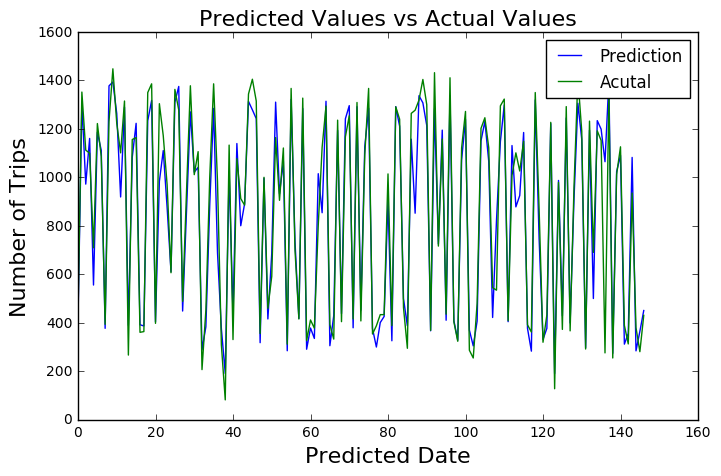

In [65]:
fs = 16
plt.figure(figsize=(8,5))
plt.plot(rfr_preds)
plt.plot(y_test)
plt.legend(['Prediction', 'Acutal'])
plt.ylabel("Number of Trips", fontsize = fs)
plt.xlabel("Predicted Date", fontsize = fs)
plt.title("Predicted Values vs Actual Values", fontsize = fs)
plt.show()